In [ ]:
!pip install -q mediapipe==0.10.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.9/33.9 MB 9.1 MB/s eta 0:00:00


In [ ]:
!wget -O embedder.tflite -q https://storage.googleapis.com/mediapipe-models/image_embedder/mobilenet_v3_small/float32/1/mobilenet_v3_small.tflite

In [ ]:
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import time
from PIL import Image
import os
from google.colab import drive

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Assume that the data files are in the following folder -- THIS WILL BE USED BY THE TA
main_folder = "/content/drive/My Drive/Colab Notebooks/Computer Vision/Data/ObjSimilarity/"

In [ ]:
ground_truth = {1: 0,
                2: 1,
                3: 1,
                4: 1,
                5: 1,
                6: 1,
                7: 1,
                8: 1,
                9: 0,
                10: 1,
                11: 1,
                12: 1,
                13: 1,
                14: 1,
                15: 1,
                16: 1,
                17: 1,
                18: 1,
                19: 0,
                20: 1}

In [ ]:
def image_grid(original_frame, num_row=3, num_col=3):
    old_row, old_col, channel = original_frame.shape

    new_row = int(old_row/num_row)
    new_col = int(old_col/num_col)

    grided = []

    for i in range(num_row):
        for j in range(num_col):
            grided.append(original_frame[i*new_row:(i+1)*new_row,j*new_col:(j+1)*new_col].copy())

    return grided


In [ ]:
def cosine_similarity(first_frame, second_frame):

    ref_mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=first_frame)
    check_mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=second_frame)

    # Create options for Image Embedder
    base_options = python.BaseOptions(model_asset_path='embedder.tflite')
    l2_normalize = True
    quantize = True
    options = vision.ImageEmbedderOptions(
    base_options=base_options, l2_normalize=l2_normalize, quantize=quantize)

    # Create Image Embedder
    with vision.ImageEmbedder.create_from_options(options) as embedder:
        start_time = time.time()

        # Format images for MediaPipe
        first_embedding_result = embedder.embed(ref_mp_image)
        second_embedding_result = embedder.embed(check_mp_image)

        # Calculate and print similarity
        similarity = vision.ImageEmbedder.cosine_similarity(
        first_embedding_result.embeddings[0],
        second_embedding_result.embeddings[0])

    return similarity, time.time() - start_time

In [ ]:
def threshold_find(need_to_check, ground_truth):

    best_threshold = None
    best_acc = 0

    for threshold in need_to_check.values():
        acc, precision, recall, F1 = eval(need_to_check, ground_truth, threshold)
        if acc >= best_acc:
            best_threshold = threshold
            best_acc = acc

    return threshold

In [ ]:
def eval(need_to_check, ground_truth, threshold):
    TP = 0
    TN = 0
    FP = 0
    FN = 0

    for i in range(1,21):
        predict = need_to_check[i] <= threshold
        if ground_truth[i] == 0:
            if predict == 0:
                TN += 1
            elif predict == 1:
                FP += 1
        elif ground_truth[i] == 1:
            if predict == 0:
                FN += 1
            elif predict == 1:
                TP += 1

    acc = (TP + TN) / 20
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    F1 = 2 * (precision*recall) / (precision+recall) if (precision+recall) > 0 else 0

    return acc, precision, recall, F1

In [ ]:
def grid_similarity(num_row=1, num_col=1):

    sub_folders = os.listdir(main_folder)
    similarity = {}

    for i in range(1,21):
        sub_folder_path = os.path.join(main_folder, str(i))
        pictures = os.listdir(sub_folder_path)
        refer_img = ""
        check_img = ""
        if "object" in pictures[0]:
            refer_img = os.path.join(sub_folder_path, pictures[0])
            check_img = os.path.join(sub_folder_path, pictures[1])
        else:
            refer_img = os.path.join(sub_folder_path, pictures[1])
            check_img = os.path.join(sub_folder_path, pictures[0])

        # read file
        refer_img_color = np.asarray(Image.open(refer_img).convert('RGB'), dtype=np.uint8)
        check_img_color = np.asarray(Image.open(check_img).convert('RGB'), dtype=np.uint8)

        # grid
        results = image_grid(check_img_color,num_row=num_row,num_col=num_col)
        tmp = float("-inf")
        for result in results:
            s, d = cosine_similarity(refer_img_color, result)
            if s >= tmp:
                tmp = s
        similarity[i] = tmp

    return similarity

In [ ]:
def grid_similarity_display(num_row=1, num_col=1):

    sub_folders = os.listdir(main_folder)
    similarity = {}

    for i in range(1,21):
        sub_folder_path = os.path.join(main_folder, str(i))
        pictures = os.listdir(sub_folder_path)
        refer_img = ""
        check_img = ""
        if "object" in pictures[0]:
            refer_img = os.path.join(sub_folder_path, pictures[0])
            check_img = os.path.join(sub_folder_path, pictures[1])
        else:
            refer_img = os.path.join(sub_folder_path, pictures[1])
            check_img = os.path.join(sub_folder_path, pictures[0])

        # read file
        refer_img_color = np.asarray(Image.open(refer_img).convert('RGB'), dtype=np.uint8)
        check_img_color = np.asarray(Image.open(check_img).convert('RGB'), dtype=np.uint8)

        # grid
        results = image_grid(check_img_color,num_row=num_row,num_col=num_col)
        fig, axs = plt.subplots(nrows=num_row, ncols=num_col)
        tmp = float("-inf")
        for i in range(num_row):
            for j in range(num_col):
                axs[i,j].imshow(results[i*num_row+j])
                axs[i,j].axis('off')

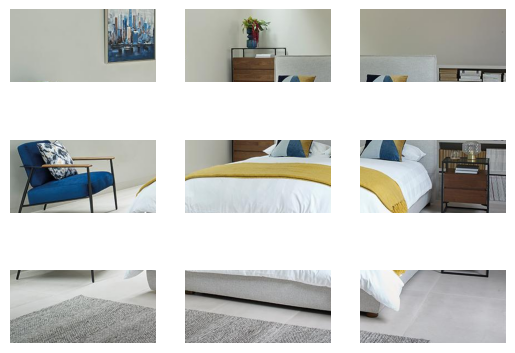

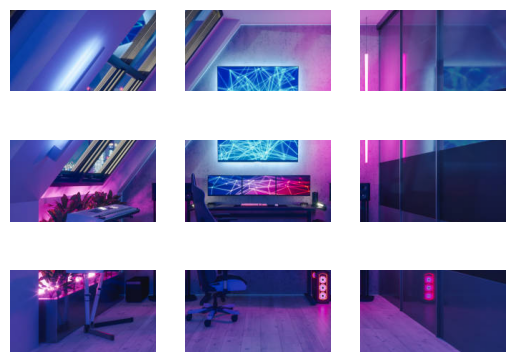

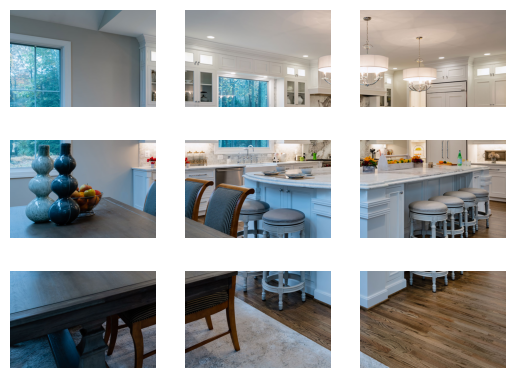

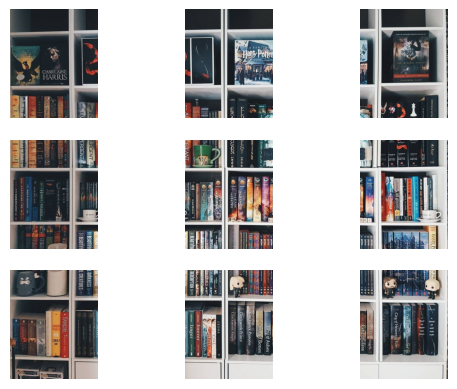

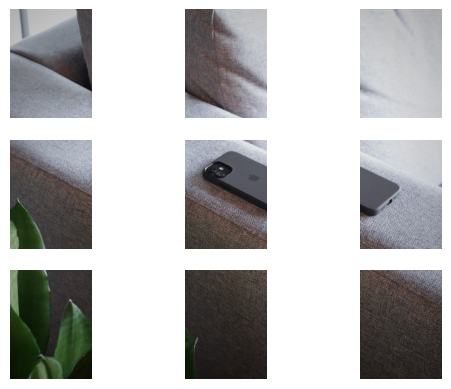

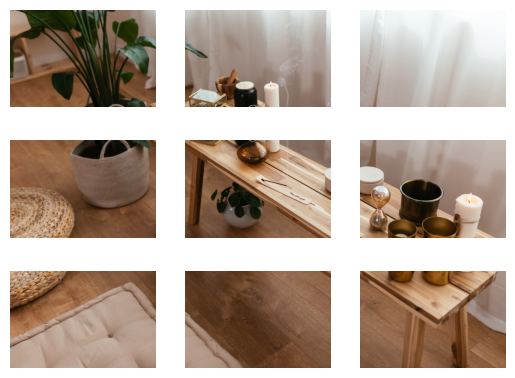

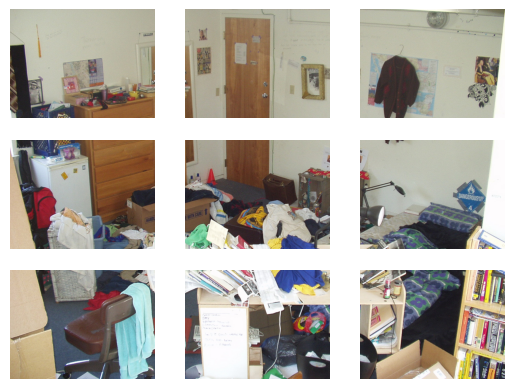

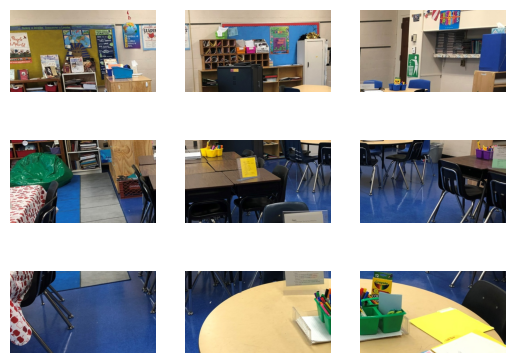

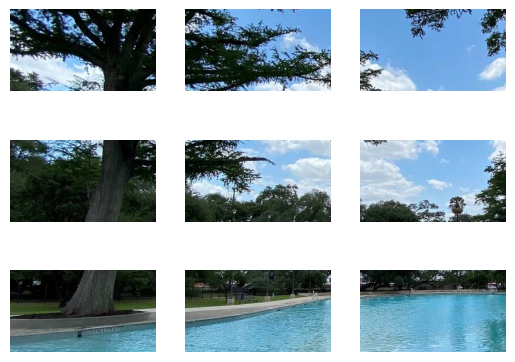

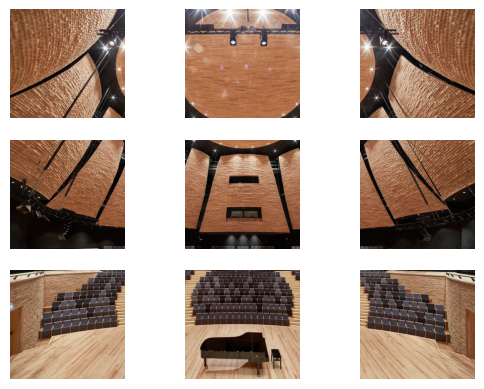

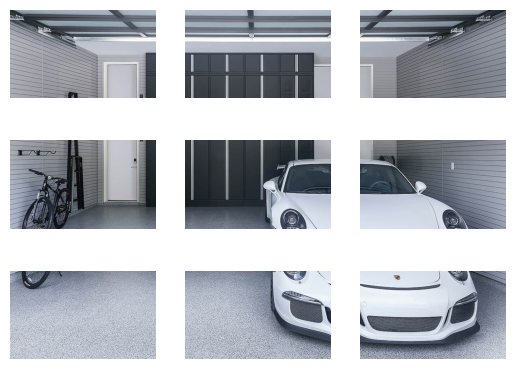

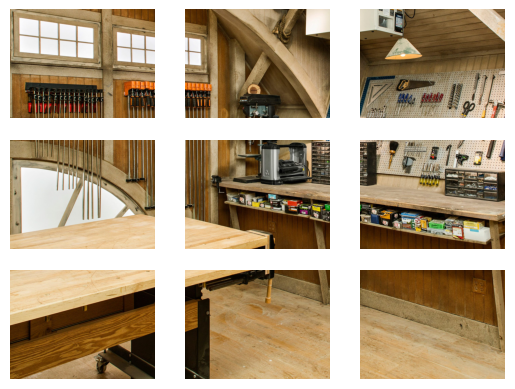

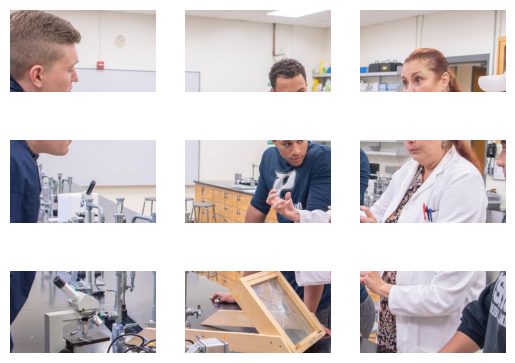

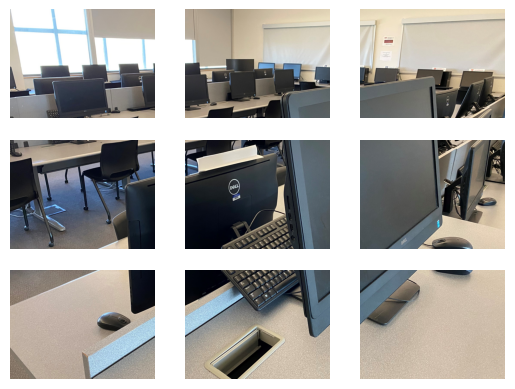

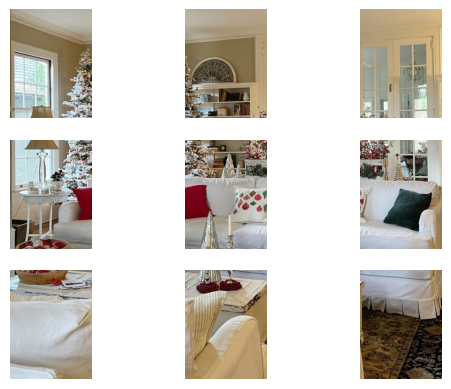

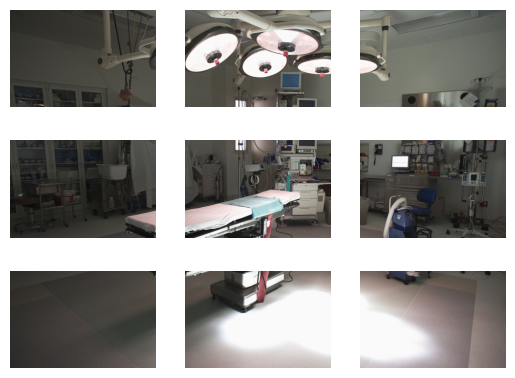

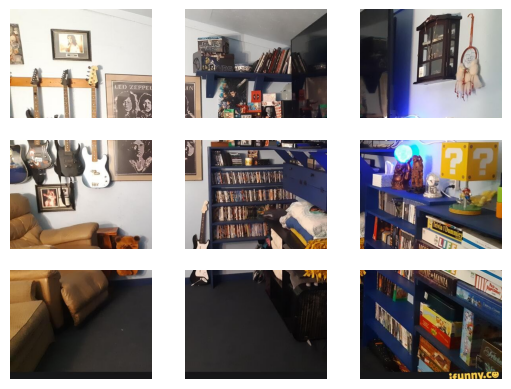

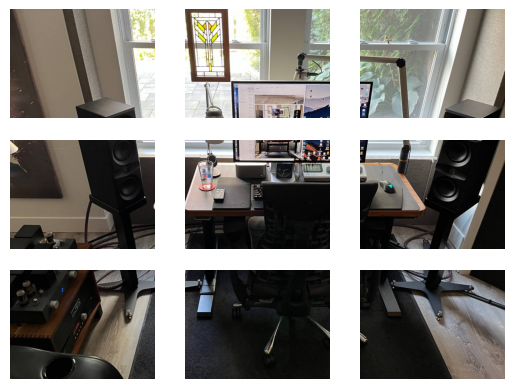

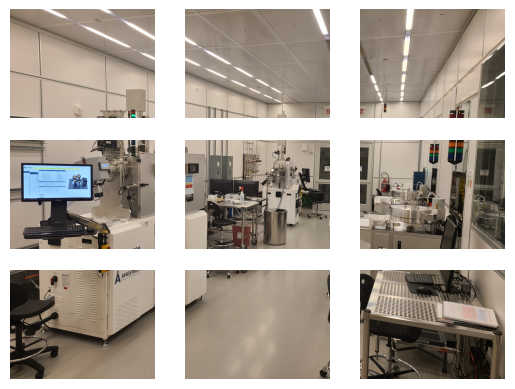

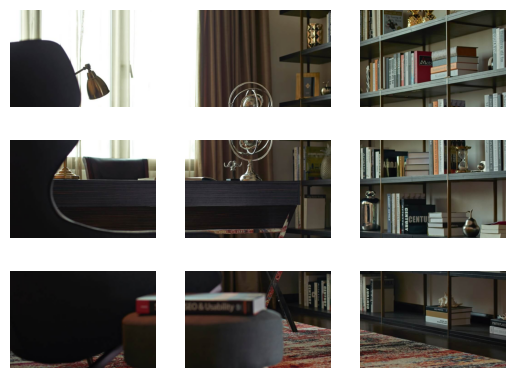

In [ ]:
grid_similarity_display(3,3)

In [ ]:
max_row = 10
max_col = 10

similarity_matrix = [[None for col in range(max_col+1)] for row in range(max_row+1)]

for row in range(1, max_row+1):
    for col in range(1, max_col+1):
        similarity_matrix[row][col] = grid_similarity(row, col)

In [ ]:
for row in range(1, max_row+1):
    for col in range(1, max_col+1):
        threshold = threshold_find(similarity_matrix[row][col], ground_truth)
        acc, precision, recall, F1 = eval(similarity_matrix[row][col], ground_truth, threshold)
        print(f"best threshold for grid {row}x{col}: {threshold}")
        print(f"{acc}\t{precision}\t{recall}\t{F1}")
        print()
    print()

best threshold for grid 1x1: 0.029375746399942285
0.5	0.8181818181818182	0.5294117647058824	0.6428571428571428

best threshold for grid 1x2: 0.041568616649404436
0.45	0.75	0.5294117647058824	0.6206896551724139

best threshold for grid 1x3: 0.04688055523741364
0.4	0.7777777777777778	0.4117647058823529	0.5384615384615384

best threshold for grid 1x4: 0.07762155028897015
0.4	0.7777777777777778	0.4117647058823529	0.5384615384615384

best threshold for grid 1x5: 0.06186516669026698
0.45	0.8	0.47058823529411764	0.5925925925925927

best threshold for grid 1x6: 0.07777457547300876
0.45	0.8	0.47058823529411764	0.5925925925925927

best threshold for grid 1x7: 0.07880557972031758
0.45	0.8	0.47058823529411764	0.5925925925925927

best threshold for grid 1x8: 0.07771424983563785
0.45	0.8	0.47058823529411764	0.5925925925925927

best threshold for grid 1x9: 0.060435112682161
0.35	0.8333333333333334	0.29411764705882354	0.4347826086956522

best threshold for grid 1x10: 0.07838550436671095
0.45	0.8	0.470